## Brain decoding prediction analysis

This notebook compares quantitative properties of the brain decoder predictions for different trained decoders / subjects / target representations.

In [2]:
from collections import defaultdict
import itertools
from pathlib import Path
import re
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from scipy import stats as st
from tqdm import tqdm_notebook
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

sys.path.append("../src")
from rsa import rsa_encodings
import util

In [3]:
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")
sentences_path = Path("../data/sentences/stimuli_384sentences.txt")
brains_path = Path("../data/brains")

bert_base_model = "uncased_L-12_H-768_A-12"
finetune_desc = "finetune-250"

In [4]:
bert_models = ["MNLI", "QQP", "SST", "SQuAD", "LM", "LM_contentonly", "LM_lmonly", "LM_scrambled", "LM_contentonly_scrambled", "LM_lmonly_scrambled"]
subjects = ["M02", "M04", "M07", "M08", "M09", "M14", "M15", "P01"]
target_runs = [1, 2, 3, 4, 5, 6, 7, 8]
steps = list(range(5, 255, 5))

### Data loading

In [5]:
PCA_DIM = 256

In [8]:
# Load model encoding data.
encodings = {}
steps_of_interest = [steps[-1]]
for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading model steps"):
    encoding_name = "encodings.%s.%s.%s-run%i-%i.npy" % (finetune_desc, bert_base_model, model, run, step)
    encoding_path = bert_encoding_path / encoding_name

    try:
        encodings[model, run, step] = util.load_encodings([encoding_path], project=PCA_DIM)
    except FileNotFoundError:
        continue

In [14]:
encs2 = {"/".join(str(x) for x in k): v for k, v in encodings.items()}

In [15]:
np.savez("../models/bert_encodings_20190508-1445.npz", **encs2)

In [35]:
# Load decoder prediction data.
predictions = {}
for subject in tqdm_notebook(subjects, desc="Subjects"):
    for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading predictions for target models", leave=False):
        decoded_path = decoder_path / ("encodings.%s.%s.%s-run%i-%i-%s.pred.npy" % (finetune_desc, bert_base_model, model, run, step, subject))
        try:
            predictions[model, run, step, subject] = np.load(decoded_path)
        except FileNotFoundError: pass
        
    # Add baseline predictions.
    baseline_path = decoder_path / ("encodings.%s-%s.pred.npy" % (bert_base_model, subject))
    predictions["_", None, None, subject] = np.load(baseline_path)

In [37]:
preds2 = {"/".join(str(x) for x in k): v for k, v in predictions.items()}

In [38]:
np.savez("../models/decoder_predictions_20190508-1445.npz", **preds2)

#### Reload from cache ..

If restarting this notebook, we can hopefully load the cached files instead:

In [39]:
predictions = np.load("../models/decoder_predictions_20190508-1445.npz")
predictions = {tuple(k.split("/")): v for k, v in predictions.items()}
encodings = np.load("../models/bert_encodings_20190508-1445.npz")
encodings = {tuple(k.split("/")): v for k, v in encodings.items()}

In [141]:
# Normalize encodings as in regression.
encodings = {k: v - v.mean(axis=0) for k, v in encodings.items()}
encodings = {k: v / np.linalg.norm(v, axis=1, keepdims=True) for k, v in encodings.items()}

### Prepare sentence data

In [40]:
sentences = util.load_sentences(sentences_path)

### Load original encodings

In [27]:
# Load pretrained model encodings.
encoding_path = bert_encoding_path / ("encodings.%s.npy" % (bert_base_model))
baseline_encoding = util.load_encodings([encoding_path], project=PCA_DIM)

### Error analysis

Averaging across subjects, how does per-sentence error change over time?

In [142]:
pred_mses = {}

In [143]:
for (model, run, step), encodings_i in encodings.items():
    mses = {}
    for subject in subjects:
        try:
            mses_s = np.linalg.norm(encodings_i - predictions[model, run, step, subject], axis=1)
        except:
            continue
        
        mses[subject] = pd.Series(mses_s, name="mse")
        
    if mses:
        pred_mses[model, int(run), int(step)] = pd.concat(mses, names=["subject"])

In [144]:
# Add original encoding MSEs.
original_mses = {}
for subject in subjects:
    original_mses[subject] = pd.Series(np.linalg.norm(baseline_encoding - predictions["_", "None", "None", subject], axis=1),
                                       name="mse")
    pred_mses["_", 0, 250] = pd.concat(mses, names=["subject"])

In [145]:
pred_mses = pd.DataFrame(pd.concat(pred_mses, names=["model", "run", "step"])).sort_index()
pred_mses.index.names = ["model", "run", "step", "subject", "sentence"]

In [146]:
pred_mses.head()

mse
model run step subject sentence          
LM    5   250  M02     0         1.095291
                       1         1.155759
                       2         1.240707
                       3         1.099487
                       4         0.994810

In [147]:
first_mses = pred_mses.loc[pd.IndexSlice["_", 0, 250, :, :], :]
last_mses = pred_mses.loc[pd.IndexSlice[:, :, 250, :, :], :]

In [148]:
first_mses.index = first_mses.index.droplevel((0, 1, 2))

In [149]:
mse_diffs = last_mses.groupby(["model", "run", "step"]) \
    .apply(lambda xs: xs.reset_index(level=(0,1,2), drop=True) - first_mses)

In [150]:
mse_diffs.head()

mse
model run step subject sentence          
LM    5   250  M02     0         0.158538
                       1         0.061520
                       2         0.154621
                       3         0.148930
                       4        -0.010163

In [151]:
mse_diffs["abs_mse"] = mse_diffs.mse.transform(np.abs)

In [152]:
mse_diffs.sort_values("abs_mse", ascending=False)

mse   abs_mse
model               run step subject sentence                    
SST                 4   250  M02     9         0.694041  0.694041
                    2   250  P01     273       0.686632  0.686632
                    6   250  M09     366       0.673520  0.673520
                    2   250  M07     59        0.665119  0.665119
                    5   250  P01     273       0.662398  0.662398
QQP                 3   250  M09     380       0.659437  0.659437
SST                 2   250  M08     237       0.656601  0.656601
                             P01     364       0.651674  0.651674
                    6   250  M15     378       0.644869  0.644869
                    5   250  M15     378       0.643039  0.643039
                    2   250  M02     364       0.641376  0.641376
                    4   250  P01     77        0.641048  0.641048
                    7   250  M09     260      -0.637881  0.637881
                    2   250  M14     230       0.637744  0.637744
                    6   250  P01     364       0.632173  0.632173
                    2   250  M09     108       0.631803  0.631803
                             M04     273       0.630218  0.630218
                             M15     378       0.623119  0.623119
                    5   250  M09     274       0.621982  0.621982
                    4   250  M02     361       0.619940  0.619940
                             M15     144       0.619019  0.619019
SQuAD               6   250  M07     9         0.617519  0.617519
SST                 1   250  M15     144       0.615611  0.615611
                    5   250  M08     360       0.615234  0.615234
                    8   250  P01     364       0.607714  0.607714
                    5   250  P01     202       0.605658  0.605658
                    3   250  M09     108       0.602676  0.602676
                    2   250  M02     361       0.602180  0.602180
                    8   250  P01     273       0.601557  0.601557
                    3   250  M14     144       0.598281  0.598281
...                                                 ...       ...
LM_lmonly_scrambled 8   250  M08     5         0.000000  0.000000
                                     4         0.000000  0.000000
                                     3         0.000000  0.000000
                                     2         0.000000  0.000000
                             M14     288       0.000000  0.000000
                                     283       0.000000  0.000000
                             M08     18        0.000000  0.000000
                             M14     279       0.000000  0.000000
                                     281       0.000000  0.000000
                             M08     36        0.000000  0.000000
                                     35        0.000000  0.000000
                             M14     280       0.000000  0.000000
                             M08     34        0.000000  0.000000
                                     33        0.000000  0.000000
                                     32        0.000000  0.000000
                                     31        0.000000  0.000000
                                     30        0.000000  0.000000
                                     29        0.000000  0.000000
                                     28        0.000000  0.000000
                                     19        0.000000  0.000000
                                     27        0.000000  0.000000
                                     26        0.000000  0.000000
                             M14     282       0.000000  0.000000
                             M08     25        0.000000  0.000000
                                     24        0.000000  0.000000
                                     23        0.000000  0.000000
                                     22        0.000000  0.000000
                                     21        0.000000  0.000000
                          

### RSA in MSE diffs

In [172]:
avg_mse_diffs = mse_diffs.groupby(["model"]).apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

sentence,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
model,,,,,,,,,,,,,,,,,,,,,
LM,0.083000,0.056588,0.044436,0.074014,0.061741,0.058982,0.075457,0.072057,0.055810,0.151042,...,0.053130,0.061852,0.048525,0.040809,0.066444,0.056421,0.073946,0.044174,0.044761,0.043002
LM_contentonly,0.076744,0.054388,0.037007,0.056081,0.058329,0.053146,0.068292,0.064711,0.049711,0.122000,...,0.050509,0.040921,0.054515,0.042412,0.054581,0.045144,0.069684,0.044598,0.040987,0.045379
LM_contentonly_scrambled,0.059538,0.070037,0.048742,0.070998,0.050678,0.051543,0.050066,0.057898,0.046423,0.069417,...,0.040899,0.039678,0.046089,0.050964,0.042663,0.065216,0.056900,0.030916,0.030681,0.037390
LM_lmonly,0.071229,0.062073,0.045457,0.067925,0.065775,0.064158,0.085805,0.069676,0.049618,0.142827,...,0.065706,0.053179,0.051743,0.045879,0.056828,0.062683,0.082861,0.045968,0.055285,0.057297
LM_lmonly_scrambled,0.039389,0.062004,0.041151,0.049486,0.031805,0.033330,0.036573,0.044344,0.036714,0.044758,...,0.037802,0.045386,0.048287,0.037555,0.048891,0.045910,0.035252,0.023775,0.028223,0.039432


In [197]:
mse_corrs = {}
for pair in itertools.combinations(avg_mse_diffs.index, 2):
    mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])

In [198]:
heatmap = np.zeros((len(bert_models), len(bert_models)))
for i, model1 in enumerate(bert_models):
    for j, model2 in enumerate(bert_models):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

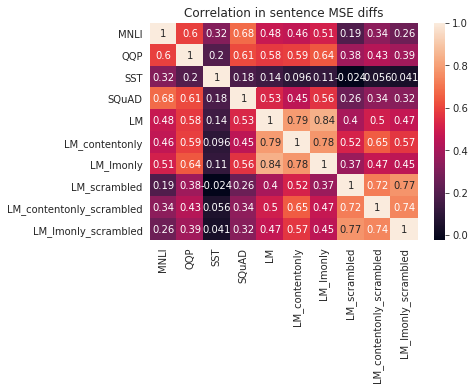

In [199]:
heatmap = pd.DataFrame(heatmap, index=bert_models, columns=bert_models)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

### RSA analysis

In [171]:
rsa_inputs = {(model, run, step): enc for (model, run, step), enc in encodings.items()
              if int(step) == steps[-1]}
rsa_sims = rsa_encodings(rsa_inputs, collapse_fn=lambda key: key[0])

100%|██████████| 2701/2701 [01:02<00:00, 44.14it/s]


In [191]:
rsa_sims_avg = rsa_sims.groupby(["model1", "model2"]).spearmanr.mean()
rsa_sims_avg

model1                    model2                  
LM                        LM                          0.981311
                          LM_contentonly              0.950049
                          LM_contentonly_scrambled    0.915102
                          LM_lmonly                   0.963033
                          LM_lmonly_scrambled         0.901257
                          LM_scrambled                0.898324
LM_contentonly            LM_contentonly              0.982328
                          LM_contentonly_scrambled    0.945681
                          LM_lmonly                   0.947291
                          LM_lmonly_scrambled         0.927460
                          LM_scrambled                0.924837
LM_contentonly_scrambled  LM_contentonly_scrambled    0.982744
                          LM_lmonly_scrambled         0.958643
LM_lmonly                 LM_contentonly_scrambled    0.910497
                          LM_lmonly                   0.979546
    

In [192]:
heatmap = np.zeros((len(bert_models), len(bert_models)))
for i, model1 in enumerate(bert_models):
    for j, model2 in enumerate(bert_models):
            
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)

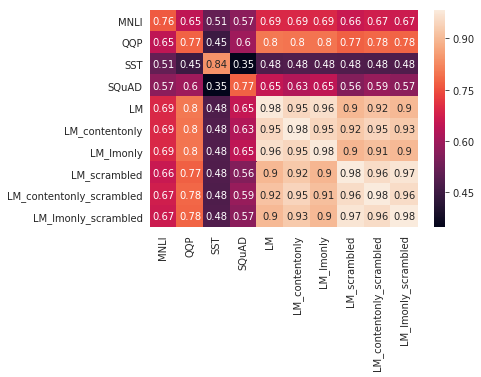

In [193]:
heatmap = pd.DataFrame(heatmap, index=bert_models, columns=bert_models)
sns.heatmap(data=heatmap, annot=True)